# Fantasy Football - Optimal Drafting Guide and Predictions

### Goals:  
1. Create a PPR drafting strategy guide.
    - Round by round analysis
    - General drafting principles
      
2. Create 2023 player ppr projections and tier list

In [1]:
# Imports
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit

import xgboost 

from sklearn.preprocessing import StandardScaler, RobustScaler

import explore_functions as e
import modeling_functions as m
from prepare import x_y_split, rmse

In [2]:
# Load dataframe
df = pd.read_csv('season1.csv',index_col=0)
df = df.sort_values('year').reset_index(drop=True)

# Exploration

### The most common fantasy football league setup is PPR (points per reception) with 12 team owners in the league that start 1 QB, 2 RB, 2 WR, 1 TE, 1 Flex, 1 Def, 1 Kicker.   
  
-This is the setup we will be exploring, so if you play in a Standard or half-PPR league you will need to adjust the advice based on your league's scoring setup.   

-We do not specifically explore Defenses or Kickers and our assumption is that you will draft them in the last two rounds of the draft.  

### Questions to explore:  
How do RBs and WRs compare to each other?  
How many points are positions scoring in comparison to each other?  
Are some positions more abundant or more scarce?  
Are there optimal rounds to select players by position?  

<Figure size 1800x900 with 0 Axes>

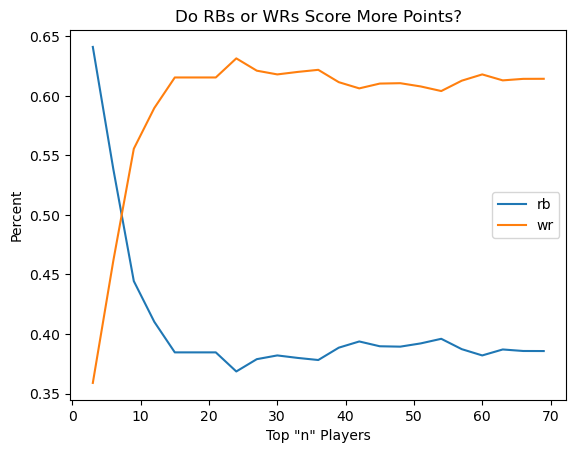

In [3]:
e.rb_wr_comparison(df)

### Viz Takeaways  
RBs occupy more of the top 7 spots than WR   
Afterwards there are many more WRs in the top 'n' players than RBs


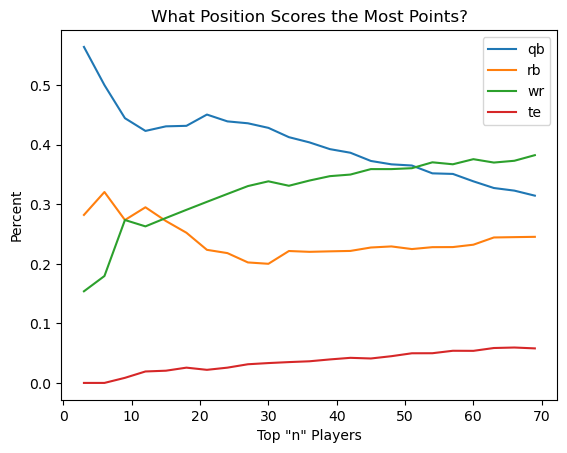

In [4]:
e.top_positions(df)

### Viz Takeaways    
  
There are many QBs in the top 70 players - abundance.   
Few TEs in top 70 - scarcity  
More WRs in top 70 than RB - relative abundance.   
Few RBs in top 70 - relative scarcity  

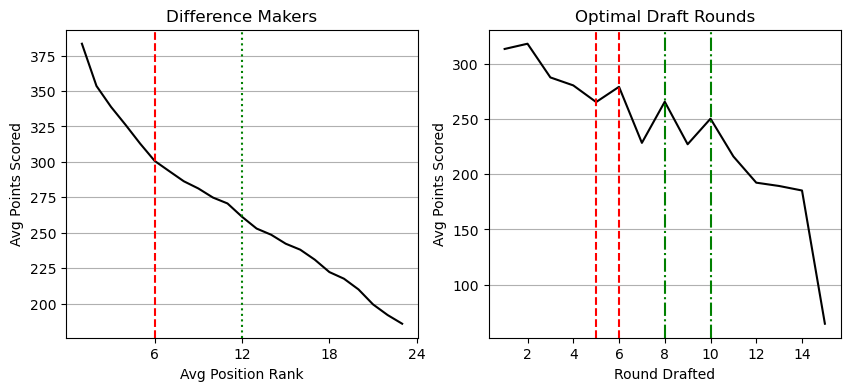

In [5]:
e.qb_draft_strat(df)

### Viz Takeaways  
  
### About Position:  
  
12 total started each week  
Top 6 are 'difference makers'  
Low risk of injury  
Many of the top players by PPR Pts are QBs = Abundance  
  
### Strategy:  
  
Grab backup 8-10, as close to 10 as possible  
First QB in rounds 5-6  
  



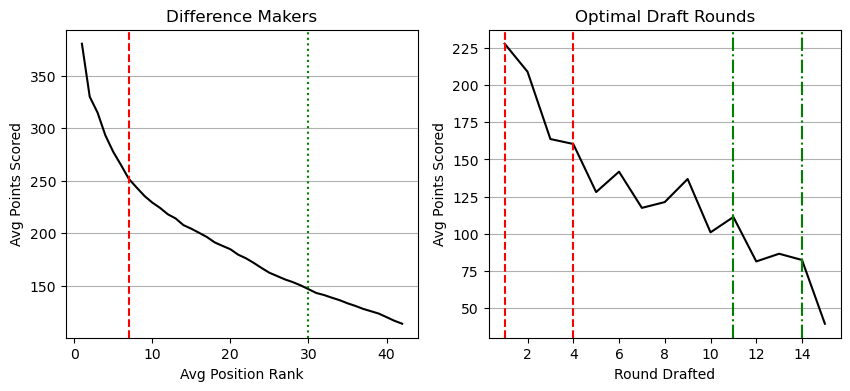

In [6]:
e.rb_draft_strat(df)

### Viz Takeaways  
### About Position:  

Top 7 are 'difference makers'  
Scarce - only 25% of top 70 players are RB as compared to 38% for WR  
Higher injury rate than WR, but very valuable due to scarcity  

### Strategy:  
  
Ideally you want two RB in your first 4 picks  
Draft minimal RB in round 5-10 as there is better value elsewhere  
11th round and later draft potential breakouts: rookies and handcuffs  




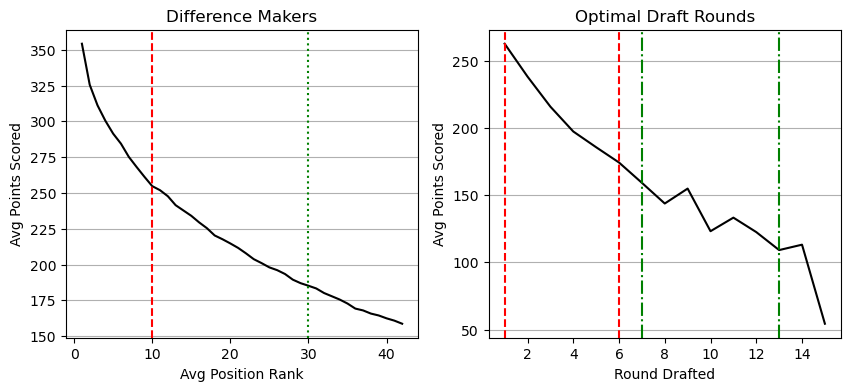

In [7]:
e.wr_draft_strat(df)

### Viz Takeaways  
  
### About Position:  
  
Top 10 'difference makers'  
Lower injury rate than RB  
Abundant - 38% of top 70 players are WR  
Lots of quality in mid rounds  
  
### Strategy:  
  
Have two WRs by round 6  
Load up at WR between rounds 6-10  
WR 10th round and later is viable but you might find more value in other positions: RB, TE  


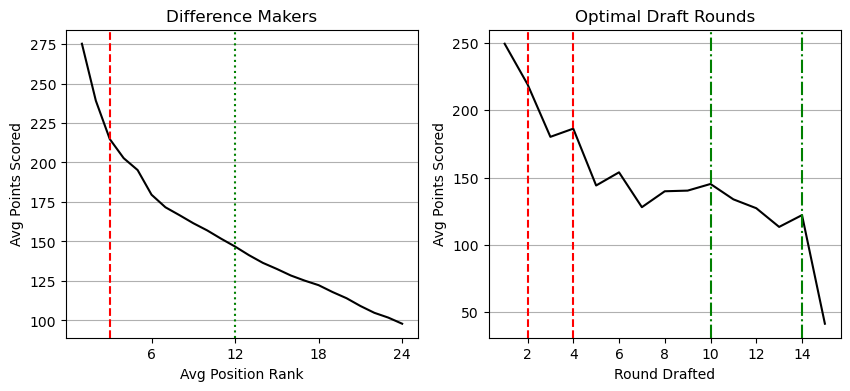

In [8]:
e.te_draft_strat(df)

### Viz Takeaways  
  
### About Position:  

Top 3 are 'difference makers'  
TEs 4-14 are typically interchangeable  
TE finishes top 70 only 6% of time  
  
### Strategy:  
  
If you want a top 3, draft where appropriate  
If don't get top 3, pickup at TE in rounds 10-14  


# Modeling

### Use machine learning models to predict ppr_pts for each player next season

In [9]:
passing, rec, rush = m.pass_rec_rush()

In [10]:
# Add 'target' column, create df for each position
df = pd.read_csv('season.csv')
df = df.groupby('player').apply(m.add_target)
df = m.var_avg_df(passing, rec, rush, df)
qb_df, rb_df, wr_df, te_df = m.split_pos(df)

In [11]:
qb_preds, qb_val_preds = m.qb_xgb_modeling(qb_df, m.qb_cols)

In [12]:
qb_rmse, qb_val_rmse = m.round_preds(rmse(qb_preds, 'xgb_preds'), rmse(qb_val_preds, 'xgb_val_preds'))

In [13]:
rb_preds, rb_val_preds = m.rb_xgb_modeling(rb_df, m.rb_cols)

In [14]:
rb_rmse, rb_val_rmse = m.round_preds(rmse(rb_preds, 'xgb_preds'), rmse(rb_val_preds, 'xgb_val_preds'))

In [15]:
wr_preds, wr_val_preds = m.wrte_xgb_modeling(wr_df, m.wr_cols)

In [16]:
wr_rmse, wr_val_rmse = m.round_preds(rmse(wr_preds, 'xgb_preds'), rmse(wr_val_preds, 'xgb_val_preds'))

In [17]:
te_preds, te_val_preds = m.wrte_xgb_modeling(te_df, m.te_cols)

In [18]:
te_rmse, te_val_rmse = m.round_preds(rmse(te_preds, 'xgb_preds'), rmse(te_val_preds, 'xgb_val_preds'))

In [20]:
m.avg_rmse(qb_rmse, qb_val_rmse, rb_rmse, rb_val_rmse, wr_rmse, wr_val_rmse, te_rmse, te_val_rmse)

The average RMSE for the train dataset is: 7.16
The average RMSE for the validate dataset is: 21.13


### Top 5 QBs for next season

In [21]:
qb_preds = pd.read_csv('qb_pred_comb.csv',index_col=0)
qb_preds.head()

,player,prediction,preds,combined
1,Patrick Mahomes,362,329,346
2,Josh Allen,343,327,335
3,Joe Burrow,309,325,317
4,Jalen Hurts,284,329,307
5,Justin Herbert,293,282,288


### Top 5 RBs for next season

In [22]:
rb_preds = pd.read_csv('rb_pred_comb.csv',index_col=0)
rb_preds.head()

,player,prediction,preds,combined
1,Austin Ekeler,261,309,285
2,Christian McCaffrey,238,306,272
3,Jordan Howard,253,253,253
4,Josh Jacobs,213,283,248
5,Derrick Henry,196,276,236


### Top 5 WRs for next season

In [23]:
wr_preds = pd.read_csv('wr_pred_comb.csv',index_col=0)
wr_preds.head()

,player,prediction,preds,combined
1,Tyreek Hill,268,322,295
2,Justin Jefferson,296,286,291
3,Stefon Diggs,245,312,279
4,Davante Adams,253,292,272
5,CeeDee Lamb,247,295,271


### Top 5 TEs for next season

In [24]:
te_preds = pd.read_csv('te_pred_comb.csv',index_col=0)
te_preds.head()

,player,prediction,preds,combined
1,Travis Kelce,228,243,236
2,Mark Andrews,191,180,185
3,T.J. Hockenson,161,202,182
4,George Kittle,168,169,169
5,Tommy Sweeney,152,152,152


# Recommendations

- Use our Ultimate Draft Guide for a position by position, round by round analysis. 
- Crush your league with your newfound knowledge

# Next Steps

- Run simulated drafts for past seasons to analyze draft strategies based on draft position
- Collect ESPN League data to determine the odds of winning any given week 